In [6]:
from app import *
from plot import *
from videohash import *
from videomatch import *


In [25]:
from config import *

In [ ]:
! pip install giftless-client

You should consider upgrading via the '/Users/pshouche/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
from giftless_client import LfsClient

In [4]:
!giftless-client --help

Usage: giftless-client [OPTIONS] COMMAND [ARGS]...

Options:
  -u, --server-url TEXT    Git LFS server URL  [required]
  -b, --bearer-token TEXT  Bearer token
  -D, --debug              Enable debug logging
  --help                   Show this message and exit.

Commands:
  download
  upload


In [2]:
!  git lfs pull

In [9]:
from faiss import *
data_path='./data'
temp_path = './temp_folder'
index_files = os.listdir(data_path)
for index_file in index_files:
    # Read from static location and write to temp storage
    print(index_file)
    binary_index = read_index_binary(os.path.join(data_path, index_file))
    write_index_binary(binary_index, f'{temp_path}/{index_file}')


b3cf94671de7aadc22970483150aafd5.index
d0369414718aa9573ff9d009f4f61cc0.index
2909574cb590231c5d1028032bd849a8.index
9c0a24aa59358ee014ded54c88eaa6c1.index
0fd24e056447f6cd068f40ba2e41828c.index
1de5e559d3d190ca09ac3fa6b40a0138.index
265732a300bbe18c4d39df108fe0c121.index
2f71b6c1d5c91c4b73eef2ebd05bd848.index
75617545ba72efdc9a7b2b140184a9c6.index
a3efa8f2e01e0964d7987e6b1e4b3b44.index


In [76]:
import faiss
binary_index = faiss.read_index_binary(fp) 

RuntimeError: Error in faiss::IndexBinary *faiss::read_index_binary(faiss::IOReader *, int) at /Users/runner/work/faiss-wheels/faiss-wheels/faiss/faiss/impl/index_read.cpp:974: Index type 4f44213c ("<!DO") not recognized

In [2]:
from videohash import filepath_from_url
fp = filepath_from_url("https://twitter.com/BoerBurgerB/status/1574736321608036353")
fp

'/var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/4f10ca2e7c20dc67b3ad076fc5631244'

In [3]:
from videohash import download_video_from_url


download_video_from_url("https://twitter.com/VVD/status/1572903775291019265?s=20&t=jcV3Yyhs5lOyGRVEPDBiVQ")

INFO:root:Downloaded video from https://twitter.com/VVD/status/1572903775291019265?s=20&t=jcV3Yyhs5lOyGRVEPDBiVQ to /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/02f4b9758a649411ff5e0d9790998989.


'/var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/02f4b9758a649411ff5e0d9790998989'

In [11]:
import hashlib
url = "https://debatgemist.tweedekamer.nl/debatten/algemene-politieke-beschouwingen-1e-termijn-kamer-0"
os.path.join(VIDEO_DIRECTORY, hashlib.sha256(url.encode()).hexdigest())

'/var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/0b71335ff6a7363b455a88c7ef4ffdd8123113435b569ad3209412786eadcb84'

In [3]:
import json
import shutil
import os
import cv2

with open('apb2022.json') as filein:
    urls, videos, url2video, video2url = [], [], {}, {}
    for item in json.load(filein):
        urls.append(item['url'])
        videos.append(item['mp4'])
        url2video[item['url']] = item['mp4']
        video2url[item['mp4']] = item['url']

for url in videos:
    filepath = filepath_from_url(url) + '.index'
    datapath = os.path.join('data', os.path.basename(filepath))
    if not os.path.exists(filepath) and os.path.exists(datapath):
        shutil.copyfile(datapath, filepath)


In [64]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.fx.all import crop
from moviepy.audio.io.AudioFileClip import AudioFileClip
from moviepy.audio.AudioClip import CompositeAudioClip
import ffmpeg
from moviepy.video.fx.all import crop


def crop_video_test(input_file, crop_percentage=0.75):
    clip  = VideoFileClip(input_file)
    ow,oh = clip.size # Original width and height
    w,h = 224, 224  # Desired width and height for faster computation
    #crop_percentage = 0.75

    return crop(clip, x_center=ow/2, y_center=oh/2, width=int(ow*crop_percentage), height=int(crop_percentage*oh)).resize((w,h))

def crop_video(input_file, output_file, crop_dim=(250,260,60,50), crop_percentage=0.75):
    resize_width = 224
    crop_percentage = 0.75

    print(f"Cropping video to width {resize_width} and crop percentage {crop_percentage}")
    
    input_video = VideoFileClip(input_file)
    framecount = int(input_video.fps * input_video.duration)
    print(f"Framecount = {framecount}")

    ow,oh = input_video.size

    # ow = video2.get(cv2.CAP_PROP_FRAME_WIDTH )
    # oh = video2.get(cv2.CAP_PROP_FRAME_HEIGHT )
    if framecount > 0:
        input_vid = ffmpeg.input(input_file)
        if resize_width == 224:
            w = 224
            h = 224
        else:
            w = resize_width
            h = (int((resize_width/ow)*oh/2))*2

    os.system(f"ffmpeg -i {input_file} -vf 'crop={str(int(crop_percentage*ow))}:{str(int(crop_percentage*oh))},scale={str(w)}:{str(h)}' {output_file}")

In [63]:
def download_video_from_url_with_crop(url):
    """Download video from url or return md5 hash as video name"""
    # TODO: Make work for Google link
    filepath = filepath_from_url(url)
    print(f"URL {url} Filepath {filepath}")
    if not os.path.exists(filepath):
        with (urllib.request.urlopen(url)) as f, open(filepath, 'wb') as fileout:
            shutil.copyfileobj(f, fileout, length=16*1024)
        logging.info(f"Downloaded video from {url} to {filepath}.")
    else:
        logging.info(f"Skipping downloading from {url} because {filepath} already exists.")
    return filepath 

In [61]:
def compute_hashes_crop(url: str, fps=FPS):
    try:
        filepath = download_video_from_url_with_crop(url)
        clip = crop_video_test(filepath)
    except IOError:
        logging.warn(f"Falling back to direct streaming from {url} because the downloaded video failed.")
        filepath = filepath_from_url(url)
        clip = crop_video_test(filepath)
  
    for index, frame in enumerate(change_ffmpeg_fps(clip, fps).iter_frames()):
        # Each frame is a triplet of size (height, width, 3) of the video since it is RGB
        # The hash itself is of size (hash_size, hash_size)
        # The uint8 version of the hash is of size (hash_size * highfreq_factor,) and represents the hash
        hashed = np.array(binary_array_to_uint8s(compute_hash(frame).hash), dtype='uint8')
        yield {"frame": 1+index*fps, "hash": hashed}

In [48]:
import faiss
def index_hashes_for_video_crop(url: str) -> faiss.IndexBinaryIVF:
    """ Compute hashes of a video and index the video using faiss indices and return the index. """
    filepath = filepath_from_url(url)
    if os.path.exists(f'{filepath}.index'):
        logging.info(f"Loading indexed hashes from {filepath}.index")
        binary_index = faiss.read_index_binary(f'{filepath}.index') 
        logging.info(f"Index {filepath}.index has in total {binary_index.ntotal} frames")
        return binary_index

    hash_vectors = np.array([x['hash'] for x in compute_hashes_crop(url)])
    logging.info(f"Computed hashes for {hash_vectors.shape} frames.")

    # Initializing the quantizer.
    quantizer = faiss.IndexBinaryFlat(hash_vectors.shape[1]*8)
    # Initializing index.
    index = faiss.IndexBinaryIVF(quantizer, hash_vectors.shape[1]*8, min(16, hash_vectors.shape[0]))
    index.nprobe = 1 # Number of nearest clusters to be searched per query. 
    # Training the quantizer.
    index.train(hash_vectors)
    #index = faiss.IndexBinaryFlat(64)
    index.add(hash_vectors)
    faiss.write_index_binary(index, f'{filepath}.index')
    logging.info(f"Indexed hashes for {index.ntotal} frames to {filepath}.index.")
    return index


def get_video_index_crop(url: str):
    """" Builds up a FAISS index for a video.
    args: 
    - filepath: location of the source video
    """
    # Url (short video) 
    video_index = index_hashes_for_video_crop(url)
    video_index.make_direct_map() # Make sure the index is indexable
    hash_vectors = np.array([video_index.reconstruct(i) for i in range(video_index.ntotal)]) # Retrieve original indices
    
    return video_index, hash_vectors

In [43]:
def compare_crop(url, target):
    """ Compare a single url (user submitted) to a single target entry and return the corresponding
    figure and decision (.json-esque list of dictionaries)
    
    args:
    - url: User submitted url which will be downloaded and cached
    - target: Target entry with a 'url' and 'mp4' attribute
    """
    target_title =  target['url']
    target_mp4 =  target['mp4']

    # Get source and target indices 
    source_index, source_hash_vectors = get_video_index_crop(url)
    target_index, _ = get_video_index_crop(target_mp4)

    # Get decent distance by comparing url index with the target hash vectors + target index
    distance = get_decent_distance(source_index, source_hash_vectors, target_index, MIN_DISTANCE, MAX_DISTANCE)
    if distance == None:
        logging.info(f"No matches found between {url} and {target_mp4}!")
        return plt.figure(), []   
    else:
        # Compare videos with heuristic distance
        lims, D, I, hash_vectors = compare_videos(source_hash_vectors, target_index, MIN_DISTANCE = distance)

        # Get dataframe holding all information
        df = get_videomatch_df(lims, D, I, hash_vectors, distance)

        # Determine change point using ROBUST method based on column ROLL_OFFSET_MODE
        change_points = get_change_points(df, metric="ROLL_OFFSET_MODE", method="ROBUST")

        # Plot and get figure and .json-style segment decision
        fig, segment_decision = plot_segment_comparison(df, change_points, video_id=target_title, video_mp4=target_mp4)
        return fig, segment_decision

def multiple_comparison_crop(url, return_figure=False):
    """ Compare a single url (user submitted) to all target entries and return the corresponding
    figures and decisions (.json-style list of dictionaries)
    
    args:
    - url: User submitted url which will be downloaded and cached
    - return_figure: Parameter to decide if to return figures or decision, needed for Gradio plotting """
    # Figure and decision (list of dicts) storage 
    figures, decisions = [], []
    for target in TARGET_ENTRIES:
        # Make comparison
        fig, segment_decision = compare_crop(url, target)

        # Add decisions to global decision list
        decisions.extend(segment_decision)
        figures.append(fig)
    
    if return_figure:
        return figures
    return decisions



In [66]:
multiple_comparison_crop("https://video.twimg.com/ext_tw_video/1572903611285258243/pu/vid/320x320/HO7k7tSagSyXm2Kd.mp4?tag=12")

INFO:root:Loading indexed hashes from /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/ea3fe68721ba75b25dabe46ae362df04.index
INFO:root:Index /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/ea3fe68721ba75b25dabe46ae362df04.index has in total 226 frames
INFO:root:Loading indexed hashes from /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/2f71b6c1d5c91c4b73eef2ebd05bd848.index
INFO:root:Index /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/2f71b6c1d5c91c4b73eef2ebd05bd848.index has in total 93111 frames
INFO:root:No matches found between https://video.twimg.com/ext_tw_video/1572903611285258243/pu/vid/320x320/HO7k7tSagSyXm2Kd.mp4?tag=12 and https://amcpwetkms-euwe.streaming.media.azure.net/0010e470-ce9d-4424-9462-8e8e10efc5af/download-20220921082013Z.mp4!
INFO:root:Loading indexed hashes from /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/ea3fe68721ba75b25dabe46ae362df04.index
INFO:root:Index /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/ea3fe68721ba75b25dabe46ae362df04.index has 

[]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1]:
from app import *
from videohash import *

INFO:root:Downloaded video from https://video.twimg.com/amplify_video/1572649668923768835/vid/480x270/nh9EVfBCy_MCv-_h.mp4?tag=14 to /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/10d499e0cee2d98a870256bf953ffe74.
INFO:root:Cropping and resizing video to (224, 224)



INFO:root:Computed hashes for (569, 32) frames.
WARNING clustering 569 points to 16 centroids: please provide at least 624 training points
INFO:root:Indexed hashes for 569 frames to /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/10d499e0cee2d98a870256bf953ffe74.index.
INFO:root:Loading indexed hashes from /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/2f71b6c1d5c91c4b73eef2ebd05bd848.index
INFO:root:Index /var/folders/w6/9kh8n81x3z9097k63m9r40h40000gp/T/2f71b6c1d5c91c4b73eef2ebd05bd848.index has in total 93111 frames
INFO:root:0.2% of frames have a match for distance '20' (1 matches for 569 frames)
INFO:root:1.2% of frames have a match for distance '22' (7 matches for 569 frames)
INFO:root:3.0% of frames have a matc

[{'Target Start Time': '00:00:00',
  'Target End Time': '00:00:08',
  'Source Start Time': '02:09:46',
  'Source End Time': '02:09:54',
  'Source Video ID': 'https://debatgemist.tweedekamer.nl/debatten/algemene-politieke-beschouwingen-1e-termijn-kamer-0',
  'Source Video .mp4': 'https://amcpwetkms-euwe.streaming.media.azure.net/0010e470-ce9d-4424-9462-8e8e10efc5af/download-20220921082013Z.mp4',
  'Uncertainty': 0.716,
  'Average Offset in Seconds': -2.386},
 {'Target Start Time': '00:00:08',
  'Target End Time': '00:00:10',
  'Source Start Time': '02:11:07',
  'Source End Time': '02:11:09',
  'Source Video ID': 'https://debatgemist.tweedekamer.nl/debatten/algemene-politieke-beschouwingen-1e-termijn-kamer-0',
  'Source Video .mp4': 'https://amcpwetkms-euwe.streaming.media.azure.net/0010e470-ce9d-4424-9462-8e8e10efc5af/download-20220921082013Z.mp4',
  'Uncertainty': 0.992,
  'Average Offset in Seconds': 64.819},
 {'Target Start Time': '00:00:10',
  'Target End Time': '00:01:36',
  'Sourc

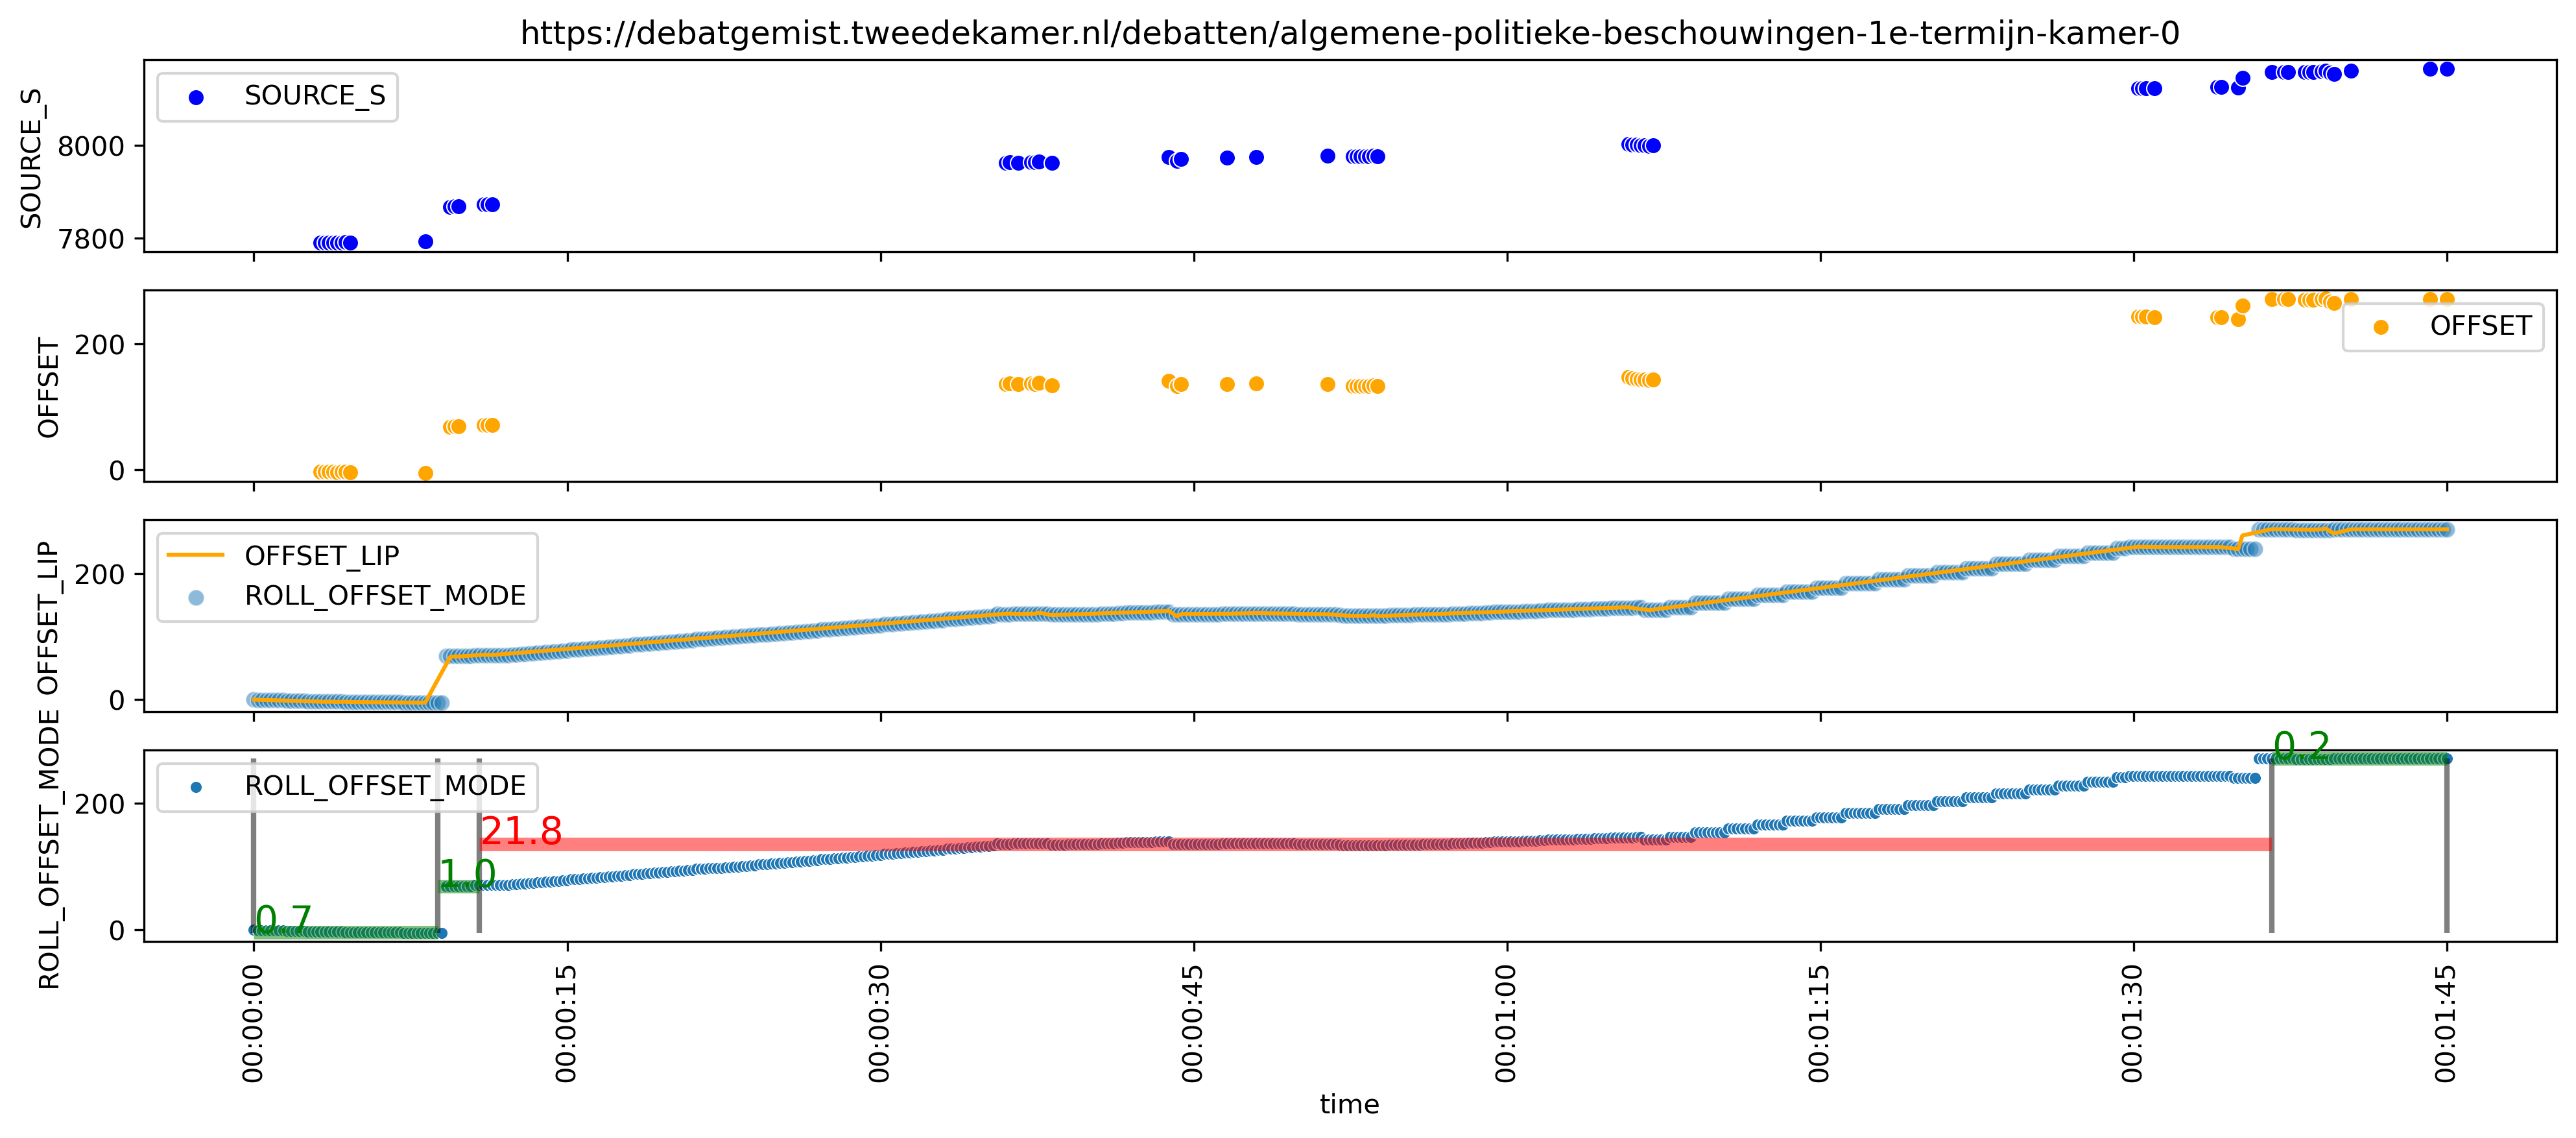

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
multiple_comparison("https://video.twimg.com/amplify_video/1572649668923768835/vid/480x270/nh9EVfBCy_MCv-_h.mp4?tag=14")